El objetivo es crear un tazador, capaz de predecir precio por metro cuadrado de una propiedad a partir de una modelo de regresion entrenado con datos registrados en Properati durante el primer semestre del 2017. A continuacion haremos una exploracion y limpieza de los datos.

### Para comenzar importaremos las librerias necesarias y el dataset correspondiente.

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr

In [2]:
df = pd.read_csv('properatti.csv')

### Veamos que forma tiene el dataset:

In [3]:
print("DF Data: \n")
print("Number of Columns:" + str(df.shape[1]))
print("Number of Rows:" + str(df.shape[0]))

DF Data: 

Number of Columns:26
Number of Rows:121220


In [144]:
df.head()

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0000,"-34.6618237,-58.5088387",-34.6618,...,40.0000,1127.2727,1550.0000,nan,nan,nan,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 ambientes tipo casa planta baja por pasillo,...",2 amb tipo casa sin expensas en pb,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0000,"-34.9038831,-57.9643295",-34.9039,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/15bob_venta_depart...,venta de departamento en décimo piso al frente...,venta depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0000,"-34.6522615,-58.5229825",-34.6523,...,55.0000,1309.0909,1309.0909,nan,nan,nan,http://www.properati.com.ar/15bod_venta_depart...,2 ambientes 3er piso lateral living comedor am...,2 amb 3er piso con ascensor apto credito,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0000,"-34.6477969,-58.5164244",-34.6478,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/15boh_venta_ph_lin...,ph 3 ambientes con patio. hay 3 deptos en lote...,ph 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0000,"-38.0026256,-57.5494468",-38.0026,...,35.0000,1828.5714,1828.5714,nan,nan,nan,http://www.properati.com.ar/15bok_venta_depart...,departamento con fantástica iluminación natura...,depto 2 amb al contrafrente zona centro/plaza ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


In [143]:
#cambiamos todos los valores de 'title' y 'description' a minuscula para facilitar la lectura
df['title'] = df['title'].str.lower()
df['description'] = df['description'].str.lower()
#volvemos a correr la lectura del df.head() para visualizar los cambios

### El dataset tiene 26 variables y 121220 observaciones. Veamos mas informacion sobre los campos:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
Unnamed: 0                    121220 non-null int64
operation                     121220 non-null object
property_type                 121220 non-null object
place_name                    121197 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               100810 non-null float64
surface_total_in_m2           81892 non-null float64
surface_covered_in_m2         101313 no

Vemos que hay muchas variables con campos sin completar. Ademas notamos que hay muchas columnas con informacion relacionada al precio, veamos que datos las componen.

In [229]:
#Para evitar ver los valores en notacion cientifica vamos a convertir el dtype float64 a todo lo anterior al punto y solo 4 decimales
pd.options.display.float_format = '{:.4f}'.format

In [139]:
df['price'].head(5)

0    62000.0000
1   150000.0000
2    72000.0000
3    95000.0000
4    64000.0000
Name: price, dtype: float64

In [138]:
df['price_aprox_local_currency'].head(5)

0   1093959.0000
1   2646675.0000
2   1270404.0000
3   1676227.5000
4   1129248.0000
Name: price_aprox_local_currency, dtype: float64

Segun el archivo descriptor de las variables, la columna 'price' representa el precio original de la propiedad mientras que la columna 'price_aprox_local_currency' muestra el precio en moneda local (en este caso usd). A primera vista suponemos que no deberian diferir, seguiremos explorando el dataset para tratar de comprender a que se deben estas diferencias.

Haremos un analisis descriptivo de las variables principales relacionadas al precio.

In [16]:
#resumen descriptivo
df['price'].describe()

count      100810.0000
mean       468525.9254
std       2260100.5891
min             0.0000
25%        110000.0000
50%        185000.0000
75%        420000.0000
max     650000000.0000
Name: price, dtype: float64

In [132]:
df['price_aprox_local_currency'].describe()

count      100810.0000
mean      4229396.8287
std       6904714.1256
min             0.0000
25%       1583309.4400
50%       2558452.5000
75%       4675792.5000
max     821271104.3000
Name: price_aprox_local_currency, dtype: float64

In [133]:
df['price_aprox_usd'].describe()

count     100810.0000
mean      239700.5769
std       391323.8757
min            0.0000
25%        89733.8800
50%       145000.0000
75%       265000.0000
max     46545445.0000
Name: price_aprox_usd, dtype: float64

In [140]:
df['price_usd_per_m2'].describe()

count    68617.0000
mean      2160.0869
std       2759.2886
min          0.6000
25%       1218.1818
50%       1800.0000
75%       2486.4118
max     206333.3333
Name: price_usd_per_m2, dtype: float64

In [141]:
df['price_per_m2'].describe()

count     87658.0000
mean       6912.2157
std       28378.6447
min           1.5102
25%        1550.0000
50%        2213.1148
75%        3355.5486
max     3999999.9600
Name: price_per_m2, dtype: float64

Revisemos la correlacion entre variables para corroborar la importancia de los datos faltantes en relacion al precio y tratar de comprender como inferir la informacion restante.

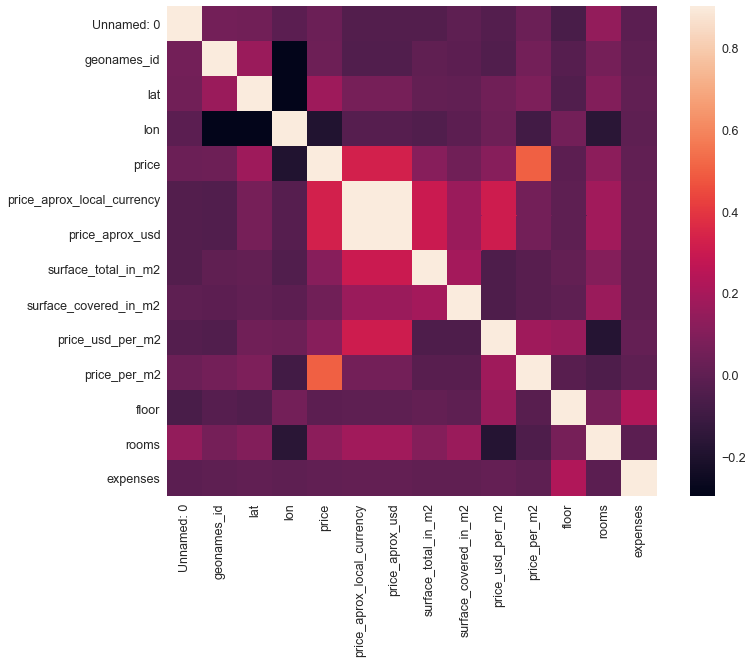

In [234]:
#plt.matshow(df.corr()) es una forma de hacerlo pero no muestra los nombres de as variables.
corr = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,vmax=0.9, square=True)
plt.show();

Podemos observar una correlacion lineal positiva entre 'price' y 'price_per_m2'. A simple vista no pareciera haber relacion entre 'floor' y 'price_per_m2' aunque si pareciera haber una leve correlacion positiva entre 'floors' y 'price_usd_per_m2'. Podemos observar correlaciones positivas cercanas a 0.5 entre las variables relacionadas al precio tanto en usd como en moneda local lo cual deberia significar constancia en los valores almacenados en el dataframe. A simple vista 'expenses' pareciera tener un leve grado de correlacion con 'floor'. De todas formas correlacion no necesariamente indica causalidad.

Veamos como se distribuyen los precios por provincia

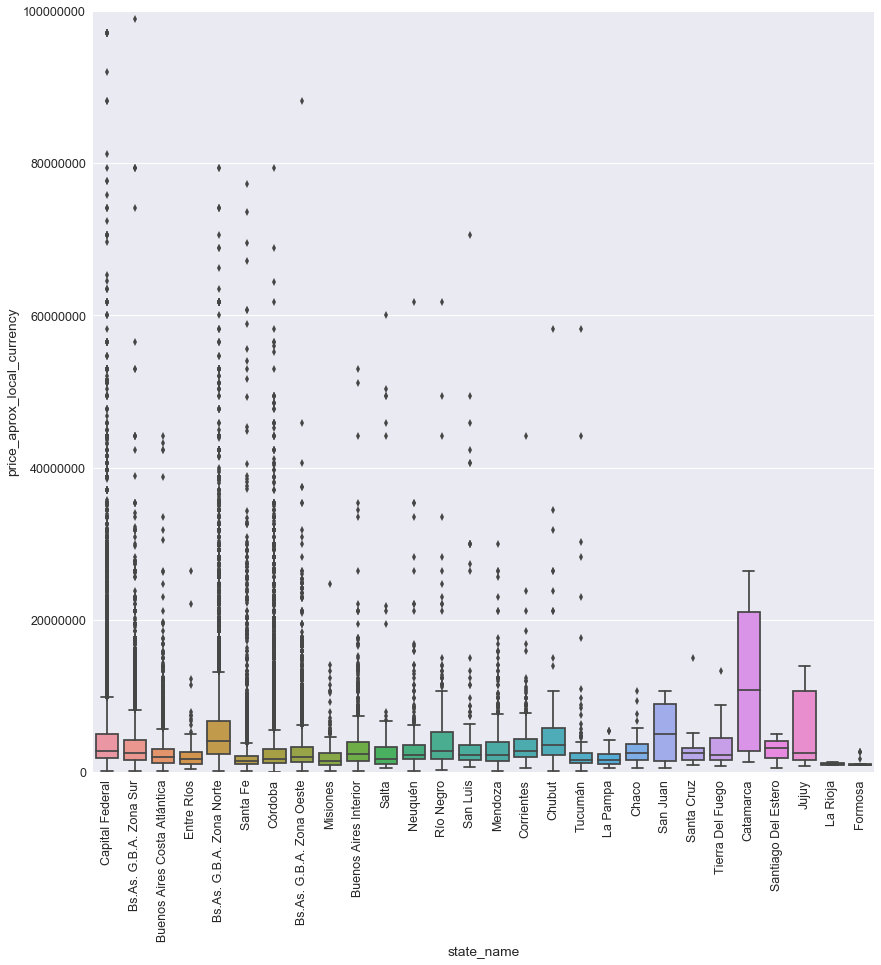

In [244]:
#box plot price_aprox_local_currency/state_name 
var = 'price_aprox_local_currency'
data = pd.concat([df[var], df['state_name']], axis=1)
f, ax =plt.subplots(figsize=(14,14))
fig = sns.boxplot(x='state_name', y=var, data=data)
plt.xticks(rotation=90)
plt.ylim(0,100000000)
plt.ticklabel_format(style='plain', axis='y')
fig.axis()
plt.show();

Observamos que Catamarca, Jujuy y San Juan toman valores mucho mas altos que el resto de las provincias. Analizaremos esto mas en profundidad luego.

Queremos visualizar la distribucion de precios mas en profundidad. Para esto generaremos boxplots de precio/barrio

Notamos que en la columna 'place_name' estan agrupados barrios cerrados y localidades, estos no son comparables. Sin embargo, en la columna 'place_with_parent_names' se encuentran agrupados valores correspondientes a la zona, la localidad, el barrio y en los casos donde corresponde tambien por barrio cerrado. Trabajaremos sobre esta columna dividida por categoria.

In [275]:
#Utilizaremos las siguientes lineas para extraer los barrios y las zonas y agregarlas a nuevas columnas en el df
df['barrio']= df['place_with_parent_names'].str.split('|', expand=True).rename(columns = lambda x: "string"+str(x+1))['string4']
df['zona']= df['place_with_parent_names'].str.split('|', expand=True).rename(columns = lambda x: "string"+str(x+1))['string3']

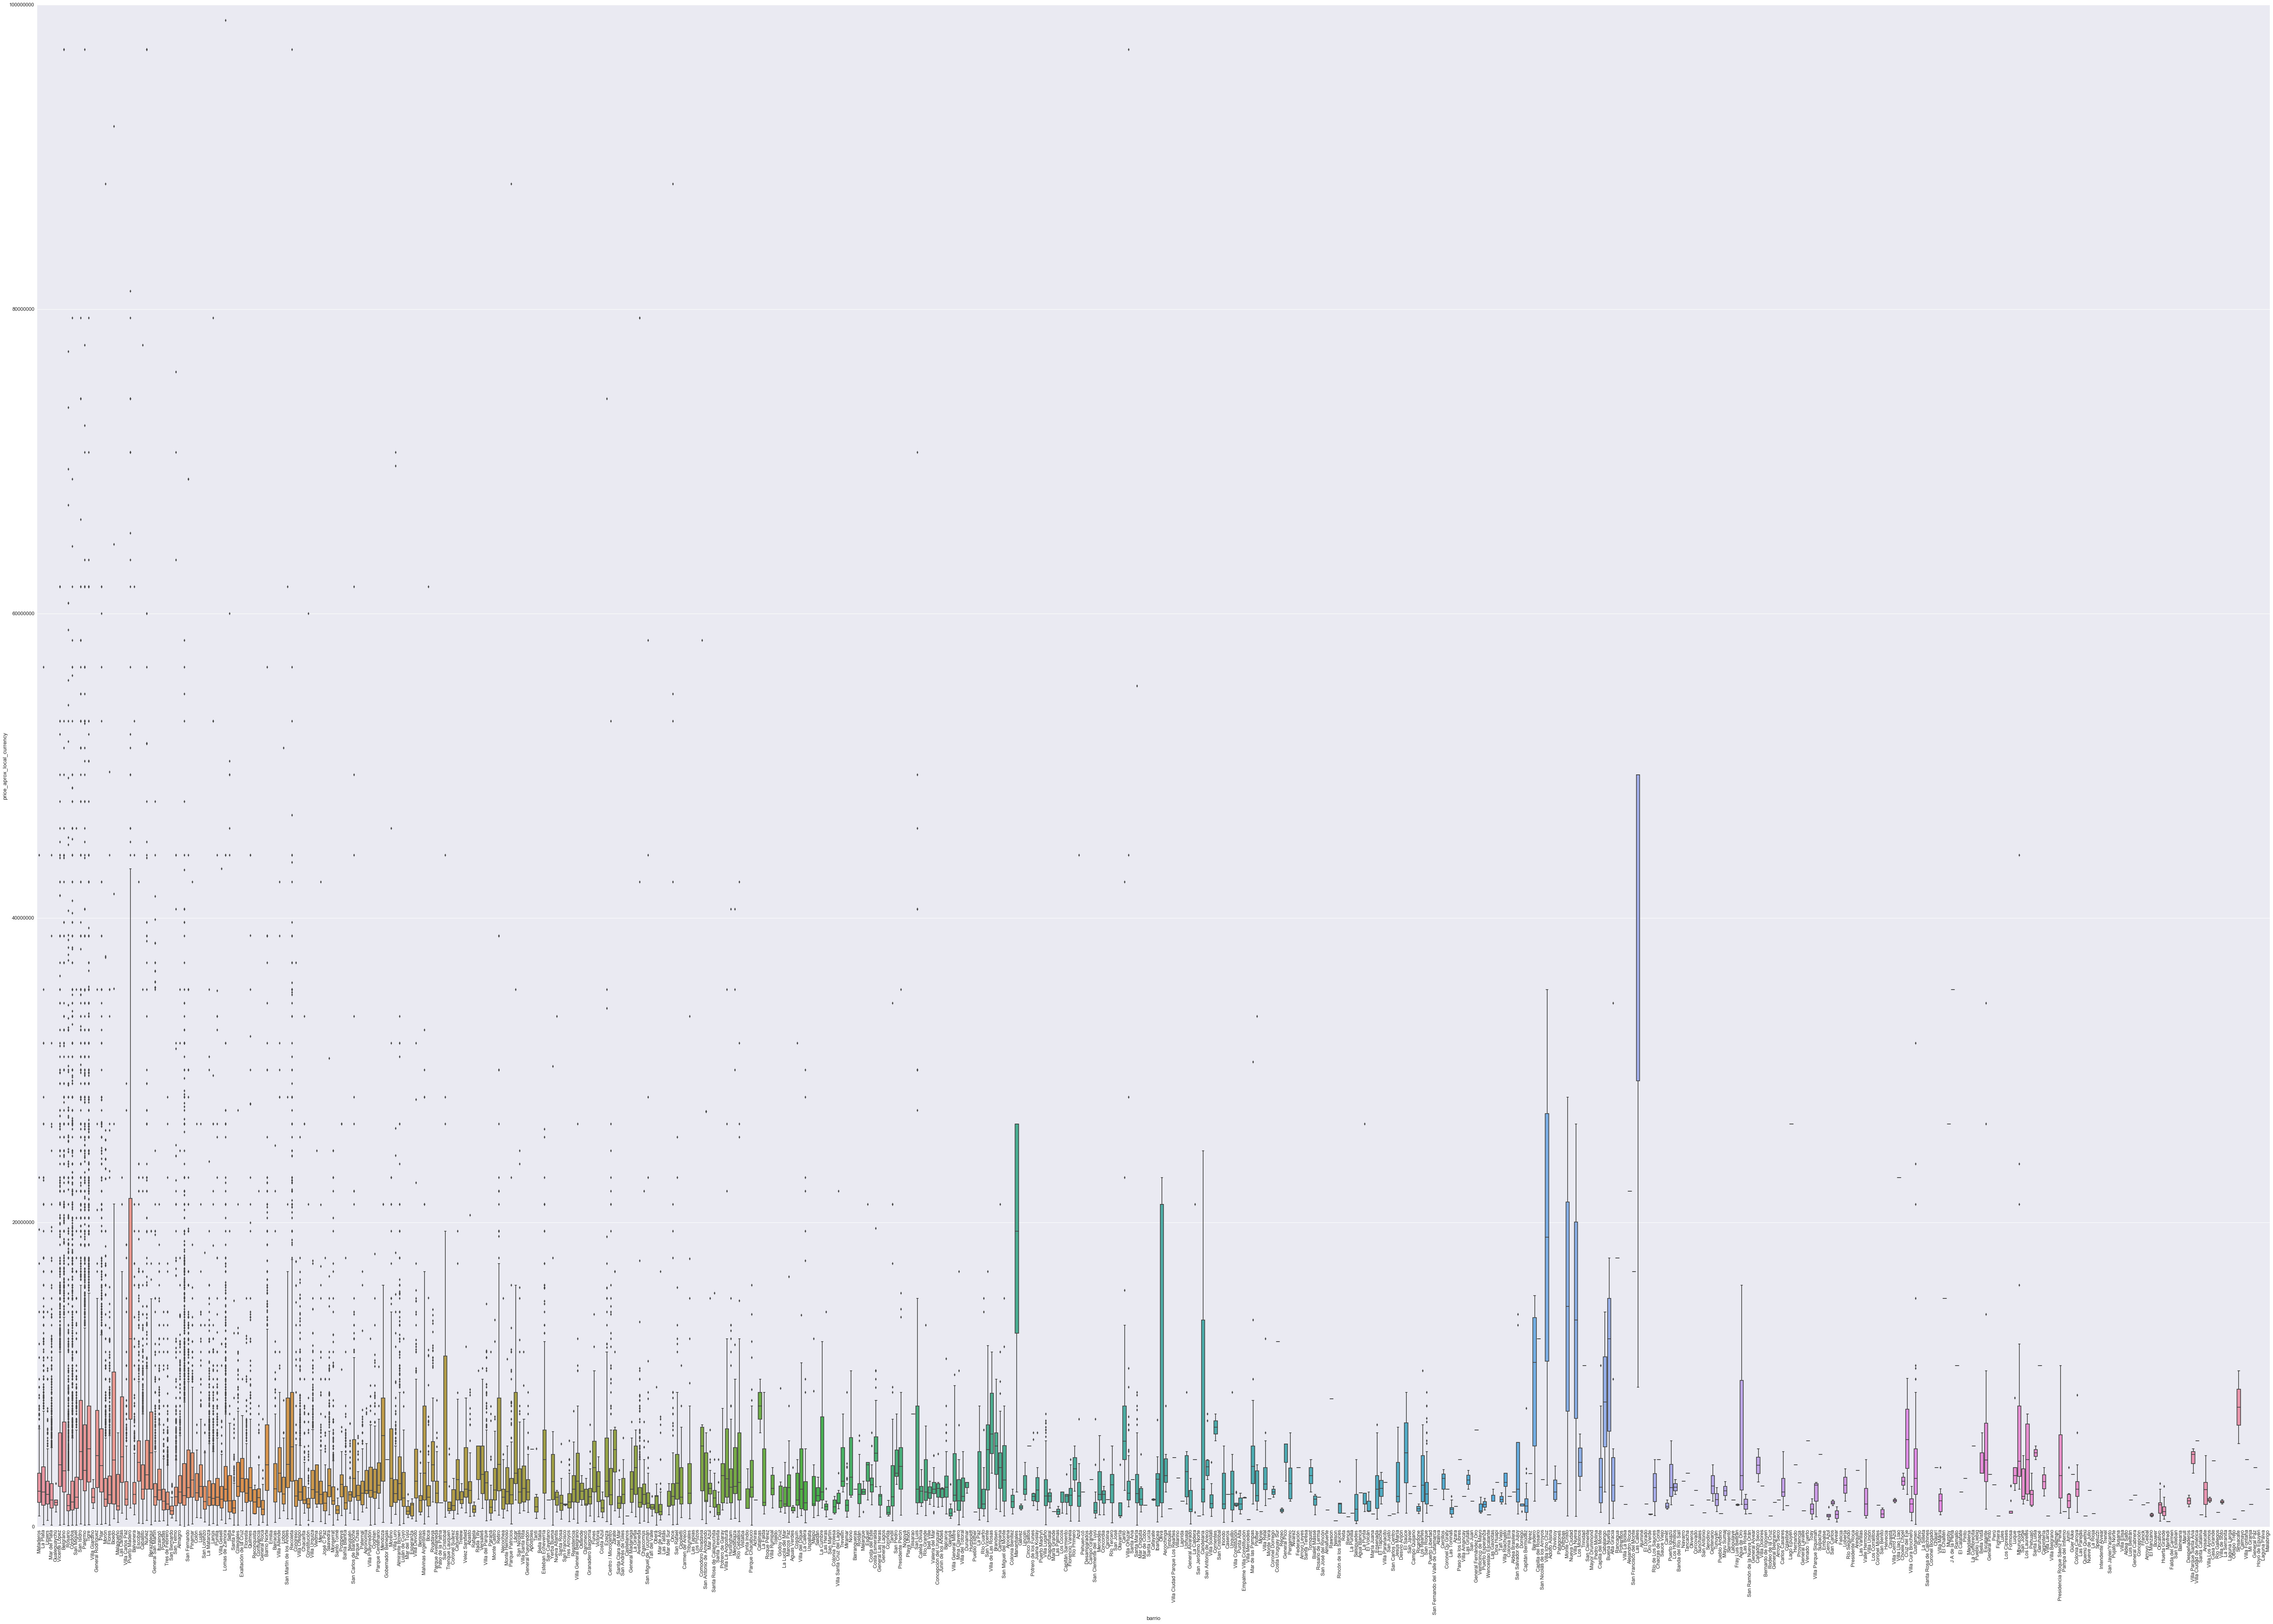

In [322]:
#boxplot price_aprox_local_currency/barrio 
var = 'price_aprox_local_currency'
data = pd.concat([df[var], df['barrio'], df['state_name']=='Capital Federal'],axis=1)
#data.apply(lambda x: df['state_name']=='Capital Federal')
f, ax =plt.subplots(figsize=(100,70))
fig = sns.boxplot(x='barrio', y=var, data=data)
plt.xticks(rotation=90)
plt.ylim(0,100000000)
plt.ticklabel_format(style='plain', axis='y')
fig.axis()
plt.show();

In [276]:
df['barrio'].describe()

count     121220
unique       539
top        Tigre
freq        8983
Name: barrio, dtype: object

El grafico tiene demasiada informacion y no es facil de leer comparativamente. la funcion describe() nos muestra que en la columna 'barrio' tenemos 539 valores unicos razon por la cual no es facil visualizar la informacion. Crearemos boxplots mas especificos para visualizar la informacion.

In [346]:
#Creamos un nuevo dataframe indexando a partir de mascaras booleanas. 
#De este modo nos aseguramos que las propiedades que tomemos en el grafico pertenezcan a Capital Federal y que tengan valores mayores 0 en su precio
capfed = df['state_name']=='Capital Federal'
conprecio = df['price_aprox_local_currency']>0
datacf = df[capfed & conprecio]
datacf

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,barrio,zona
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0000,"-34.6618237,-58.5088387",-34.6618,...,1550.0000,nan,nan,nan,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 ambientes tipo casa planta baja por pasillo,...",2 amb tipo casa sin expensas en pb,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,Mataderos,Capital Federal
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0000,"-34.6522615,-58.5229825",-34.6523,...,1309.0909,nan,nan,nan,http://www.properati.com.ar/15bod_venta_depart...,2 ambientes 3er piso lateral living comedor am...,2 amb 3er piso con ascensor apto credito,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,Mataderos,Capital Federal
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0000,"-34.6477969,-58.5164244",-34.6478,...,nan,nan,nan,nan,http://www.properati.com.ar/15boh_venta_ph_lin...,ph 3 ambientes con patio. hay 3 deptos en lote...,ph 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...,Liniers,Capital Federal
7,7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0000,"-34.5598729,-58.443362",-34.5599,...,3450.0000,nan,nan,nan,http://www.properati.com.ar/15bot_venta_depart...,excelente monoambiente a estrenar amplio super...,jose hernandez 1400 monoambiente estrenar cat...,https://thumbs4.properati.com/1/IHxARynlr8sPEW...,Belgrano,Capital Federal
8,8,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0000,"-34.5598729,-58.443362",-34.5599,...,3250.0000,nan,nan,nan,http://www.properati.com.ar/15bou_venta_depart...,excelente dos ambientes estrenar amplio super...,"jose hernandez 1400 dos ambientes estrenar ,...",https://thumbs4.properati.com/2/J3zOjgaFHrkvnv...,Belgrano,Capital Federal
13,13,sell,apartment,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,3430234.0000,NaN,nan,...,3723.3333,nan,1.0000,nan,http://www.properati.com.ar/15bp9_venta_depart...,torre i mondrian. 3 ambientes con terraza y d...,vitraux palermo,https://thumbs4.properati.com/2/ZTUjkRzTz6YvcU...,Palermo,Capital Federal
14,14,sell,apartment,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,3430234.0000,NaN,nan,...,4770.9677,nan,1.0000,nan,http://www.properati.com.ar/15bpa_venta_depart...,torre ii dalí. ambiente unico divisible.vitrau...,vitraux palermo,https://thumbs4.properati.com/8/Uay2dC732CNlRw...,Palermo,Capital Federal
16,16,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0000,"-34.6523561177,-58.5016239381",-34.6524,...,2438.7755,nan,4.0000,nan,http://www.properati.com.ar/15bpj_venta_ph_mat...,ventas mataderos al frente duplex 4 amb.- plan...,venta-mataderos-duplex 4 amb.,https://thumbs4.properati.com/7/XSdJtiE8ZkWgon...,Mataderos,Capital Federal
19,19,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,3430234.0000,"-34.580503566,-58.4058744847",-34.5805,...,3645.8333,nan,3.0000,nan,http://www.properati.com.ar/15bq8_venta_depart...,excelente semipiso al contra frente en bulnes ...,"bulnes y libertador: espectacular pulmón, con ...",https://thumbs4.properati.com/8/1y9fKHLee-aQQj...,Palermo,Capital Federal
21,21,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,3430234.0000,"-34.590926,-58.4116653",-34.5909,...,3705.4795,nan,4.0000,nan,http://www.properati.com.ar/15bqd_venta_depart...,"excelente zona, multiples medios de transporte...",departamento de 4 ambientes en venta en palermo,https://thumbs4.properati.com/0/P6wPIXB1wJFLVU...,Palermo,Capital Federal


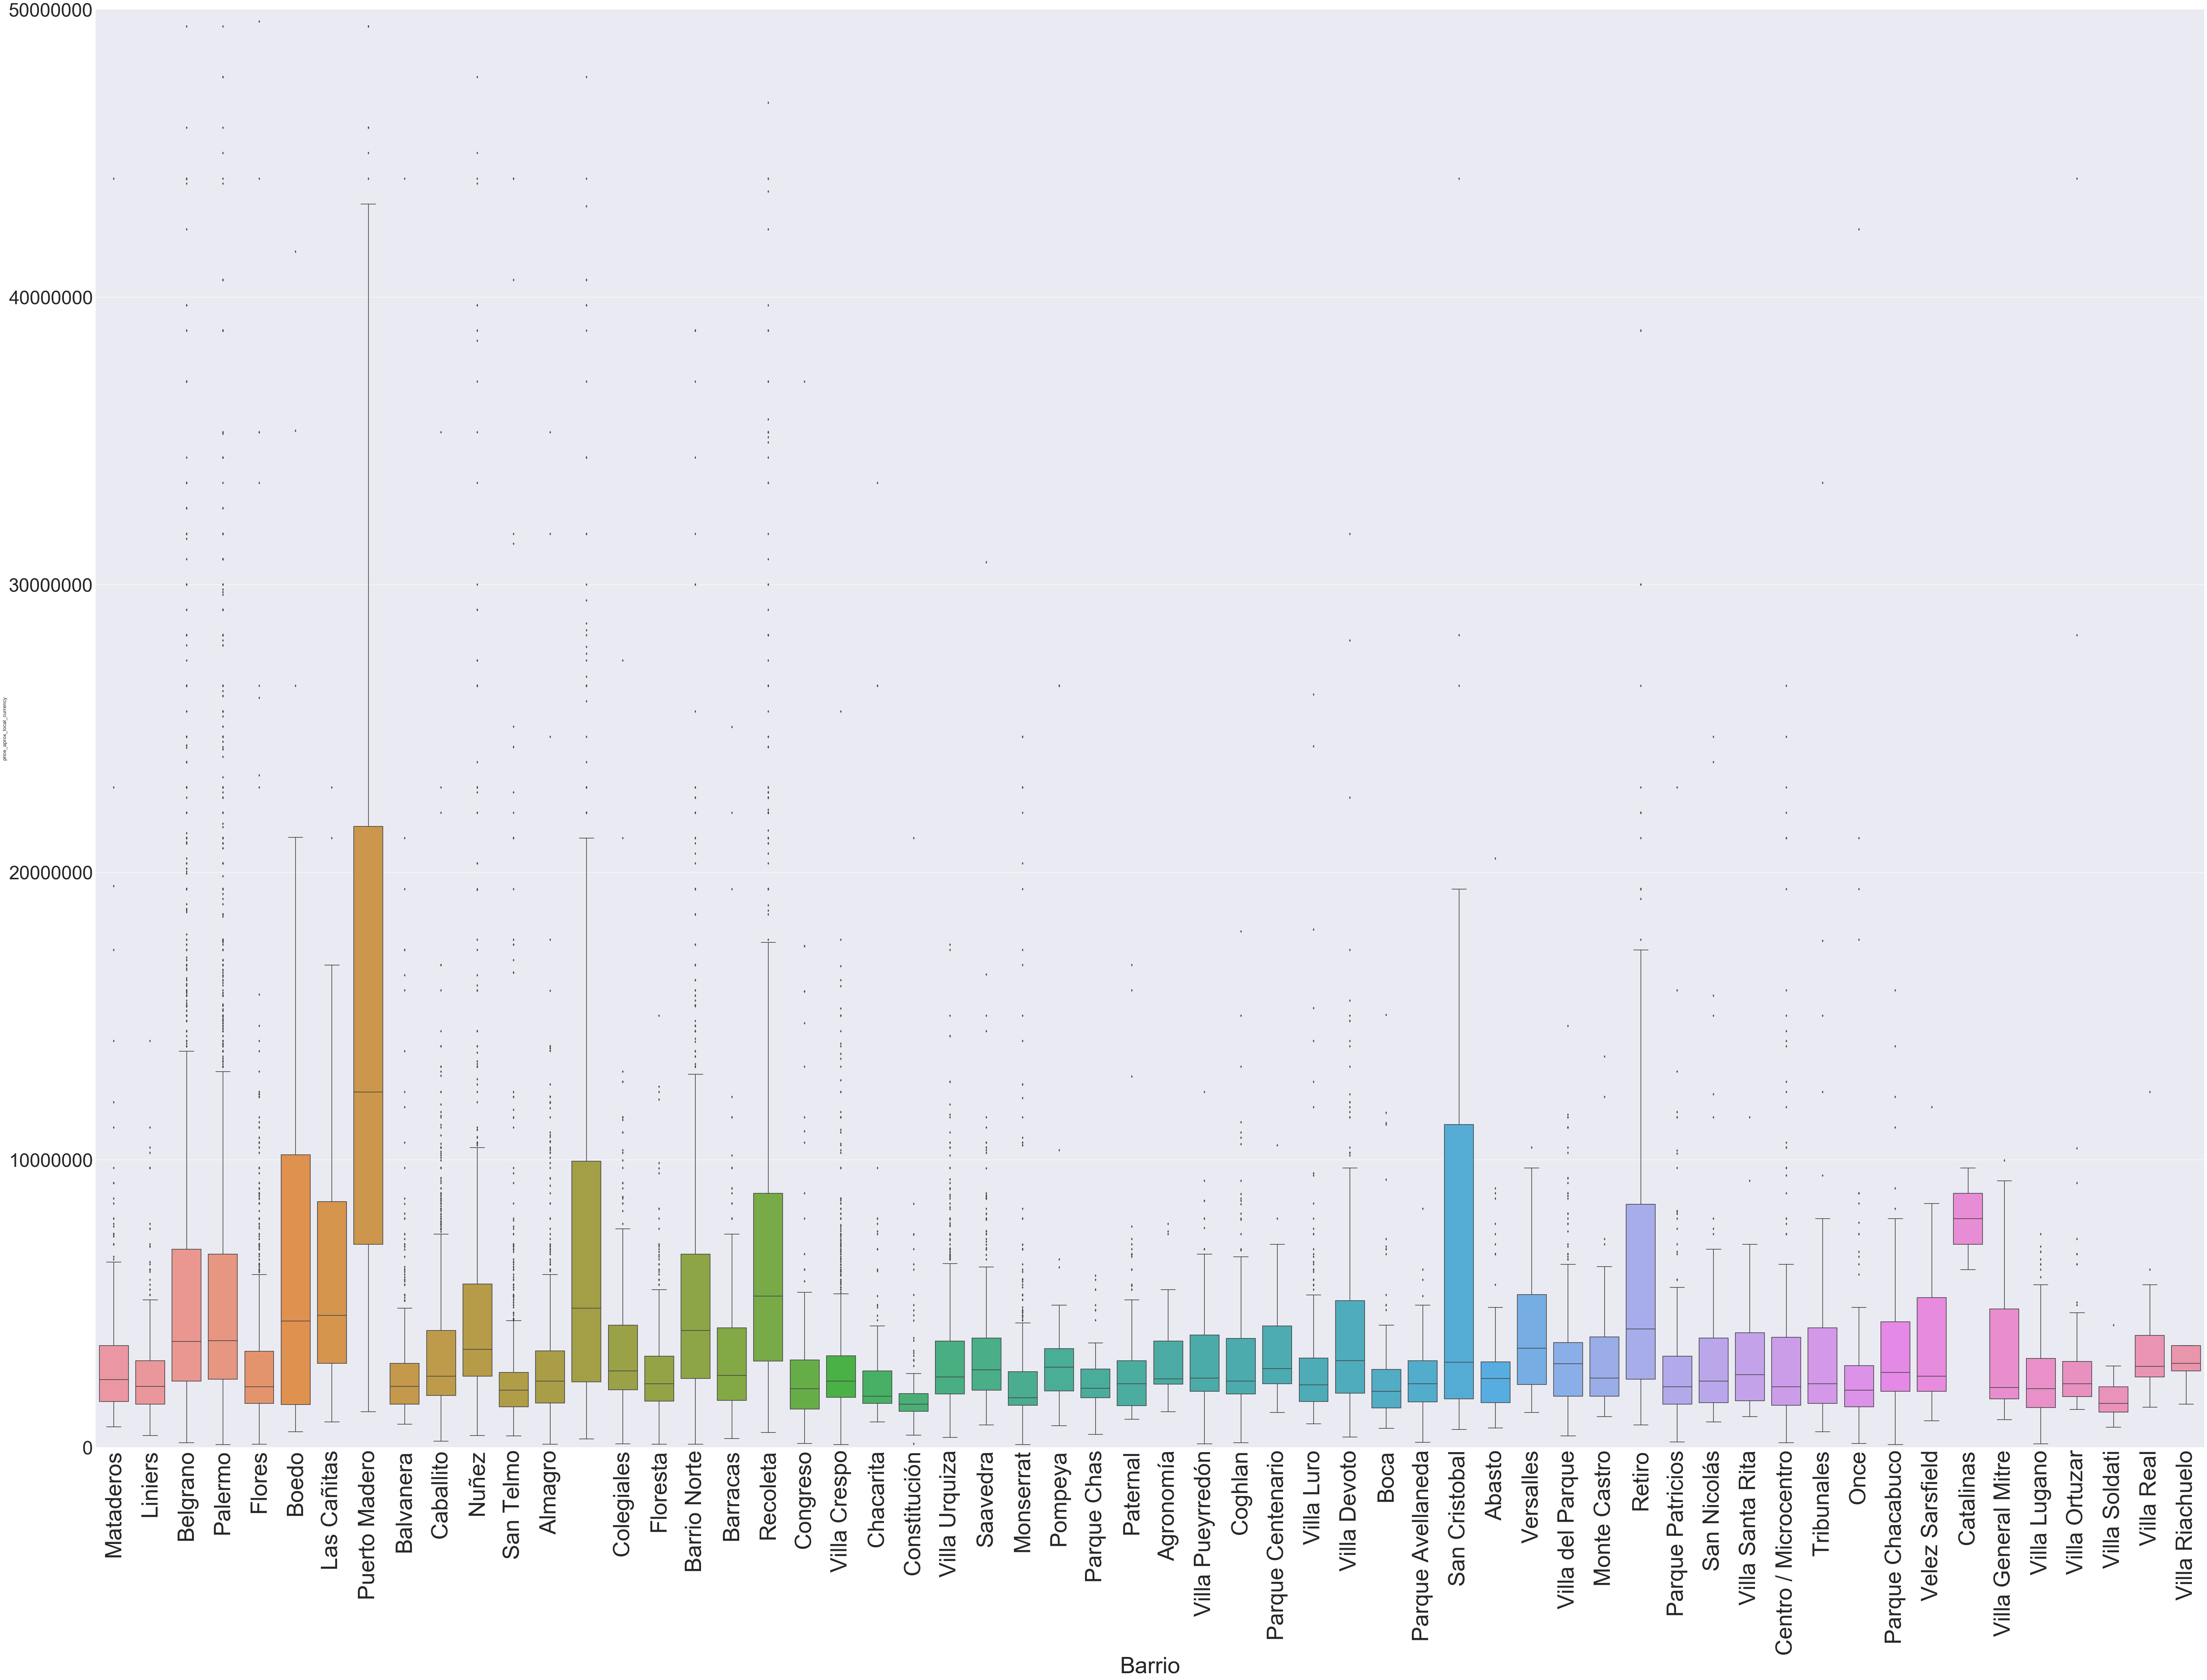

In [397]:
#boxplot price_aprox_local_currency/barrio en Capital Federal
datacf = df[capfed & conprecio]
f, ax =plt.subplots(figsize=(100,70))
fig = sns.boxplot(x=datacf['barrio'], y=datacf['price_aprox_local_currency'], data=datacf)
plt.xticks(rotation=90, fontsize=60)
plt.yticks(fontsize=50)
plt.xlabel('Barrio', fontsize=60)
plt.ylim(0,50000000)
plt.ticklabel_format(style='plain', axis='y')
fig.axis()
plt.show();

In [349]:
gbanorte = df['state_name']=='Bs.As. G.B.A. Zona Norte'
conprecio = df['price_aprox_local_currency']>0
datazn= df[gbanorte & conprecio]
datazn
#imprimimos la tabla para corroborar que haya filtrado correctamente

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,barrio,zona
6,6,sell,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Argentina,Bs.As. G.B.A. Zona Norte,3430511.0000,"-34.5329567,-58.5217825",-34.5330,...,1666.6667,nan,nan,nan,http://www.properati.com.ar/15bor_venta_ph_mun...,muy buen ph al frente con entrada independient...,"muy buen ph al frente dos dormitorios , patio,...",https://thumbs4.properati.com/5/6GOXsHCyDu1aGx...,Vicente López,Bs.As. G.B.A. Zona Norte
11,11,sell,house,San Miguel,|Argentina|Bs.As. G.B.A. Zona Norte|San Miguel|,Argentina,Bs.As. G.B.A. Zona Norte,nan,"-34.5390571,-58.7196093",-34.5391,...,nan,nan,nan,nan,http://www.properati.com.ar/15bp0_venta_casa_s...,"entrada de coche, jardin, living en desnivel, ...",chalet,https://thumbs4.properati.com/4/pH0MnS_2zCGOHR...,San Miguel,Bs.As. G.B.A. Zona Norte
12,12,sell,apartment,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3430813.0000,"-34.4860195,-58.5038139",-34.4860,...,3194.4444,nan,nan,nan,http://www.properati.com.ar/15bp4_venta_depart...,excelente departamento 2 ambientes contrafrent...,excelente departamento 2 ambientes contrafrent...,https://thumbs4.properati.com/6/wgSui4rTYqPncO...,San Isidro,Bs.As. G.B.A. Zona Norte
15,15,sell,house,Bella Vista,|Argentina|Bs.As. G.B.A. Zona Norte|San Miguel...,Argentina,Bs.As. G.B.A. Zona Norte,3436061.0000,"-34.5879112015,-58.6987828445",-34.5879,...,nan,nan,nan,nan,http://www.properati.com.ar/15bpd_venta_casa_b...,ultima unidad disponiblehaus boulevard: metros...,haus village / bella vista / 115m² mas patio /...,https://thumbs4.properati.com/6/F7EIhDPQfafSlp...,San Miguel,Bs.As. G.B.A. Zona Norte
17,17,sell,apartment,Barrio El Golf,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,nan,"-34.4087174767,-58.6343892841",-34.4087,...,4038.4615,nan,3.0000,nan,http://www.properati.com.ar/15bpl_venta_depart...,excelente 3 ambientes en un 6 piso y con terra...,3 ambientes en venta en acqua golf 1 en nordel...,https://thumbs4.properati.com/8/txJsOWitsI5tjM...,Tigre,Bs.As. G.B.A. Zona Norte
18,18,sell,house,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|,Argentina,Bs.As. G.B.A. Zona Norte,3427753.0000,"-34.425087,-58.5796585",-34.4251,...,2111.1111,nan,nan,nan,http://www.properati.com.ar/15bq1_venta_casa_t...,casa sobre lote al golf en barrio san isidro l...,"casa en venta en barrio san isidro labrador, t...",https://thumbs4.properati.com/6/4N9cpurqmDMKEX...,Tigre,Bs.As. G.B.A. Zona Norte
23,23,sell,apartment,Pilar,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|Pilar|,Argentina,Bs.As. G.B.A. Zona Norte,nan,NaN,nan,...,1952.3810,nan,2.0000,nan,http://www.properati.com.ar/15bqt_venta_depart...,"hermoso departamento, ubicado en la calle almi...","excelente departamento, impecable!!! apto cred...",https://thumbs4.properati.com/8/BHyv2zmce3bVoU...,Pilar,Bs.As. G.B.A. Zona Norte
26,26,sell,house,Barrio San Gabriel,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Barr...,Argentina,Bs.As. G.B.A. Zona Norte,nan,"-34.3640924,-58.6897345",-34.3641,...,1394.7368,nan,nan,nan,http://www.properati.com.ar/15bqx_venta_casa_b...,casa en venta en complejo villanueva barrio sa...,casa muy linda en san gabriel villanueva,https://thumbs4.properati.com/2/DWZjGcq_Z-PKSC...,Tigre,Bs.As. G.B.A. Zona Norte
27,27,sell,house,Estancias del Pilar,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|Esta...,Argentina,Bs.As. G.B.A. Zona Norte,nan,"-34.4794863,-58.9845412",-34.4795,...,1529.4118,nan,nan,nan,http://www.properati.com.ar/15bqz_venta_casa_e...,estancias propone vivir rodeados de naturaleza...,excelente propiedad!!!! en estancias del pilar,https://thumbs4.properati.com/9/5zWFkmq9zHuXyZ...,Pilar,Bs.As. G.B.A. Zona Norte
30,30,sell,house,Pilar,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|,Argentina,Bs.As. G.B.A. Zona Norte,3429979

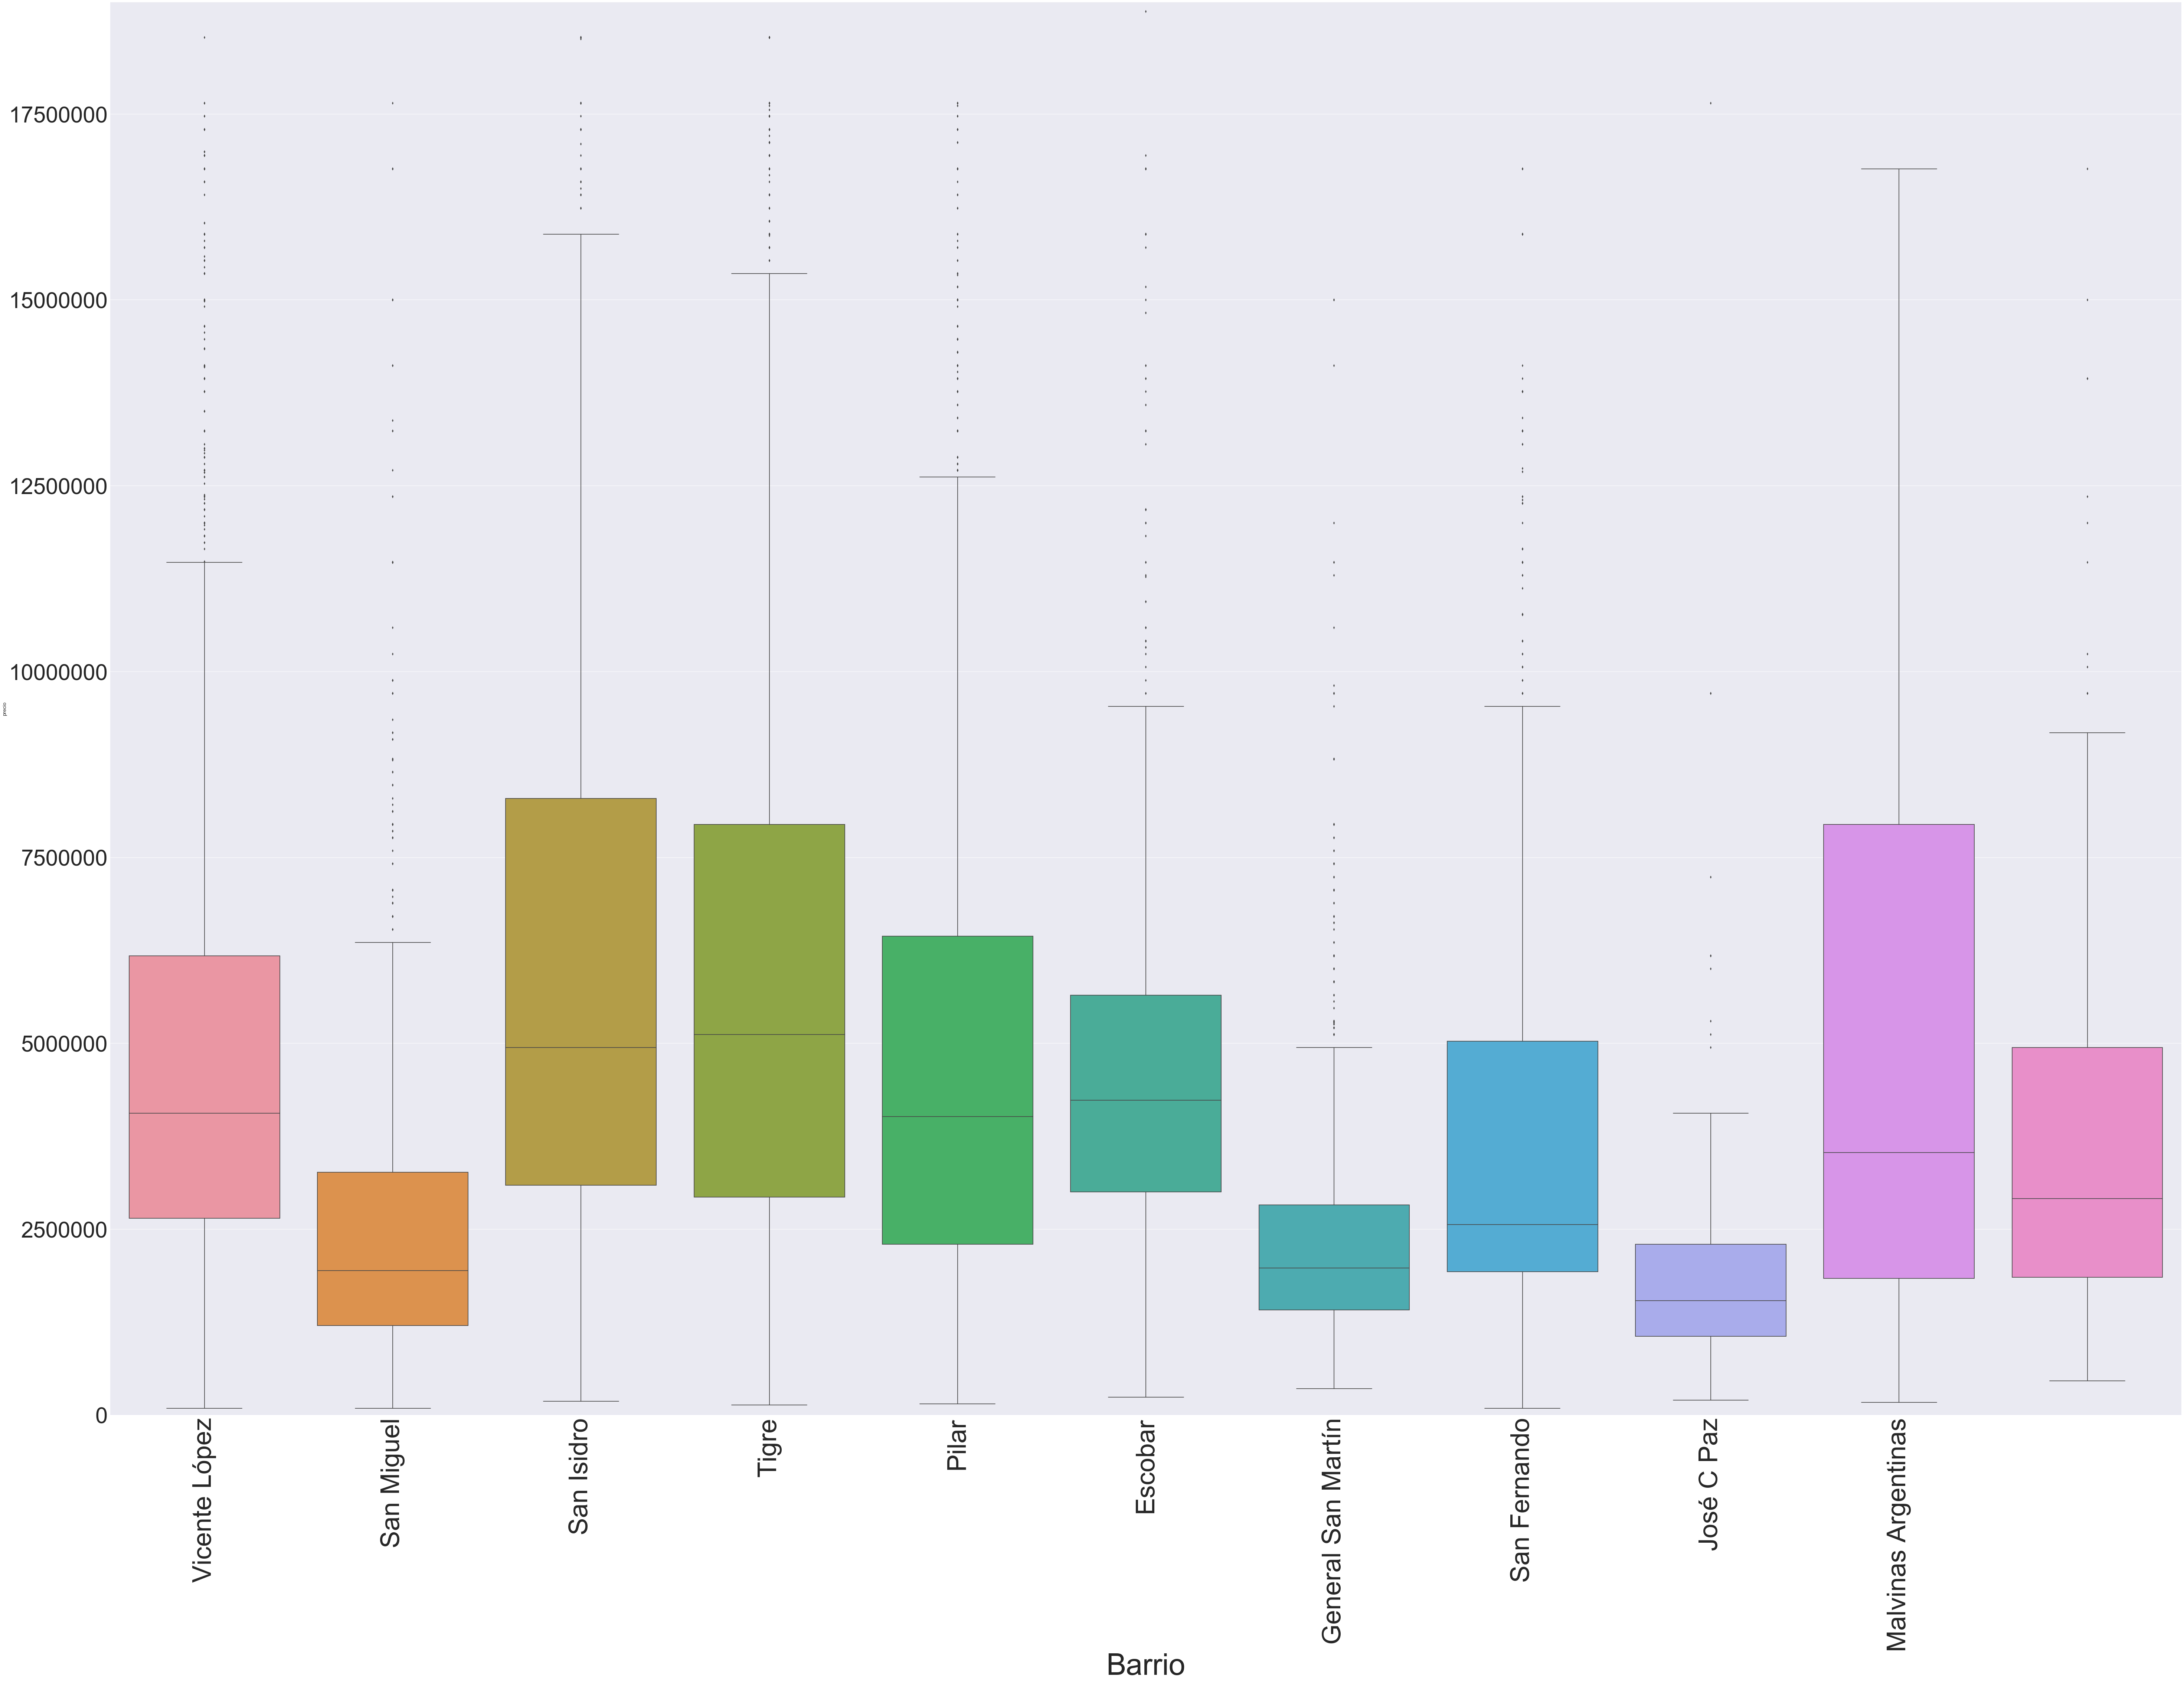

In [403]:
#boxplot price_aprox_local_currency/barrio en GBA Zona Norte
datazn = df[gbanorte & conprecio]
f, ax =plt.subplots(figsize=(100,70))
fig = sns.boxplot(x=datazn['barrio'], y=datazn['price_aprox_local_currency'], data=datazn)
plt.xticks(rotation=90, fontsize=70)
plt.yticks(fontsize=60)
plt.xlabel('Barrio', fontsize=80)
plt.ylim(0,19000000)
plt.ticklabel_format(style='plain', axis='y')
fig.set(ylabel='precio')
fig.axis()
plt.show();

In [404]:
datazn['price_aprox_local_currency'].describe()

count       24058.0000
mean      5722413.4793
std       6656723.2130
min         89061.1400
25%       2403180.9000
50%       4058235.0000
75%       6704910.0000
max     247023000.0000
Name: price_aprox_local_currency, dtype: float64

Haremos un analisis descriptivo de cada uno de los barrios. Comenzamos con San isidro

In [408]:
#distribucion san isidro
ensani = datazn['barrio']=='San Isidro'
dfsani = datazn[ensani]

In [409]:
dfsani

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,barrio,zona
12,12,sell,apartment,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3430813.0000,"-34.4860195,-58.5038139",-34.4860,...,3194.4444,nan,nan,nan,http://www.properati.com.ar/15bp4_venta_depart...,excelente departamento 2 ambientes contrafrent...,excelente departamento 2 ambientes contrafrent...,https://thumbs4.properati.com/6/wgSui4rTYqPncO...,San Isidro,Bs.As. G.B.A. Zona Norte
50,50,sell,apartment,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|,Argentina,Bs.As. G.B.A. Zona Norte,3428983.0000,"-34.4825362878,-58.5878735289",-34.4825,...,3606.5574,nan,4.0000,nan,http://www.properati.com.ar/15bud_venta_depart...,departamento a estrenar en arboris la horqueta...,excelente departamento a estrenar en arboris l...,https://thumbs4.properati.com/3/X_43TvEETZz-xI...,San Isidro,Bs.As. G.B.A. Zona Norte
56,56,sell,house,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3428983.0000,"-34.4815405,-58.537634",-34.4815,...,1685.8238,nan,nan,nan,http://www.properati.com.ar/15bv0_venta_casa_s...,"chalet clasico, ladrillo a la vista, techos de...",chalet con buen jardin - zona jockey,https://thumbs4.properati.com/9/nx7f745tdbIT4S...,San Isidro,Bs.As. G.B.A. Zona Norte
58,58,sell,house,Acassuso,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3436508.0000,"-34.4739708766,-58.496611619",-34.4740,...,3750.0000,nan,nan,nan,http://www.properati.com.ar/15bve_venta_casa_a...,magnífica residencia con calidad de construcci...,"magnífica residencia en venta, ubicada en el e...",https://thumbs4.properati.com/6/dsYU6-j6mhmHTL...,San Isidro,Bs.As. G.B.A. Zona Norte
105,105,sell,house,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3430813.0000,NaN,nan,...,2125.0000,nan,nan,nan,http://www.properati.com.ar/15d20_venta_casa_m...,"impecable casa en martã­nez, vã­as a libertado...","casa 1280m² con 3 plantas en paso, juan jose 6...",https://thumbs4.properati.com/6/3PVBopXvgS96IN...,San Isidro,Bs.As. G.B.A. Zona Norte
106,106,sell,house,Acassuso,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3436508.0000,NaN,nan,...,3750.0000,nan,nan,nan,http://www.properati.com.ar/15d22_venta_casa_a...,magnã­fica residencia con calidad de construcc...,"casa 1300m² con 3 plantas en paz, josé c. 700,...",https://thumbs4.properati.com/7/lxonCHXJy_Q74g...,San Isidro,Bs.As. G.B.A. Zona Norte
107,107,sell,house,Acassuso,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3436508.0000,NaN,nan,...,3875.0000,nan,nan,nan,http://www.properati.com.ar/15d28_venta_casa_a...,"unica propiedad en excelente zona, libertador ...","casa 1300m² con 2 plantas en paz, josé c. 700,...",https://thumbs4.properati.com/8/mW-EZMZlmk9Dk3...,San Isidro,Bs.As. G.B.A. Zona Norte
109,109,sell,apartment,Boulogne Sur Mer,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,nan,NaN,nan,...,916.6667,2.0000,nan,nan,http://www.properati.com.ar/15d2f_venta_depart...,"excelente departamento en el ""barrio san isidr...","departamento, san isidro, boulogne sur mer, po...",NaN,San Isidro,Bs.As. G.B.A. Zona Norte
111,111,sell,PH,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|,Argentina,Bs.As. G.B.A. Zona Norte,3428983.0000,NaN,nan,...,1777.7778,nan,nan,nan,http://www.properati.com.ar/15d2o_venta_ph_san...,"ph en planta alta en el centro de san isidro, ...","ph en martin y omar 100, bs.as. g.b.a. zona no...",https://thumbs4.properati.com/4/OrgZOnmyNhnRPY...,San Isidro,Bs.As. G.B.A. Zona Norte
112,112,sell,apartment,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|,Argentina,Bs.As. G.B.A. Zona Norte,3428983.0000,

In [411]:
dfsani.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2923 entries, 12 to 121216
Data columns (total 28 columns):
Unnamed: 0                    2923 non-null int64
operation                     2923 non-null object
property_type                 2923 non-null object
place_name                    2923 non-null object
place_with_parent_names       2923 non-null object
country_name                  2923 non-null object
state_name                    2923 non-null object
geonames_id                   2742 non-null float64
lat-lon                       739 non-null object
lat                           739 non-null float64
lon                           739 non-null float64
price                         2923 non-null float64
currency                      2923 non-null object
price_aprox_local_currency    2923 non-null float64
price_aprox_usd               2923 non-null float64
surface_total_in_m2           2049 non-null float64
surface_covered_in_m2         2791 non-null float64
price_usd_per_m2   

Vemos que hay en total 2923 propiedades en San Isidro de las cuales todas tienen cargado el precio en usd y en ars y un buen porcentaje (2791 totales) el precio por m2 en ars. Veamos como se distribuyen los precios 

In [414]:
dfsani['price_aprox_local_currency'].describe()

count        2923.0000
mean      7541667.3414
std      10009417.3160
min        183070.1500
25%       3087787.5000
50%       4940460.0000
75%       8292915.0000
max     194089500.0000
Name: price_aprox_local_currency, dtype: float64

Exploremos la columna property_type para tratar de comprender por que los valores en catamarca, san juan y jujuy son tanto mas altos que en el resto de las localidades.

In [427]:
encatamarca = df['state_name']=='Catamarca'
conprecio = df['price_aprox_local_currency']>0
datacm= df[encatamarca & conprecio]
datacm

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,barrio,zona
6643,6643,sell,apartment,Manantiales,|Argentina|Catamarca|Manantiales|,Argentina,Catamarca,3845035.0000,NaN,nan,...,nan,nan,nan,nan,http://www.properati.com.ar/15v25_venta_depart...,moderno apartamento con vista al mar de 3 dorm...,apartamentos en manantiales,https://thumbs4.properati.com/5/SUt13V7-w-BqtF...,Manantiales,Catamarca
6644,6644,sell,apartment,Manantiales,|Argentina|Catamarca|Manantiales|,Argentina,Catamarca,3845035.0000,NaN,nan,...,9166.6667,nan,nan,nan,http://www.properati.com.ar/15v26_venta_depart...,"sobre el mar, apartamento de 3 dormitorios en ...",apartamentos en manantiales,https://thumbs4.properati.com/5/KiW4tpTlrt452z...,Manantiales,Catamarca
8677,8677,sell,apartment,Manantiales,|Argentina|Catamarca|Manantiales|,Argentina,Catamarca,3845035.0000,NaN,nan,...,3678.9298,nan,nan,nan,http://www.properati.com.ar/161sc_venta_depart...,"casa en complejo de alta categoriacute;a, con ...",apartamentos en manantiales,https://thumbs4.properati.com/2/RS3wm03QyjR40C...,Manantiales,Catamarca
8678,8678,sell,apartment,Manantiales,|Argentina|Catamarca|Manantiales|,Argentina,Catamarca,3845035.0000,NaN,nan,...,3979.9331,nan,nan,nan,http://www.properati.com.ar/161sf_venta_depart...,"casa en complejo de alta categoriacute;a, con ...",apartamentos en manantiales,https://thumbs4.properati.com/3/yBHBhkx2n8C7dM...,Manantiales,Catamarca
8679,8679,sell,apartment,Manantiales,|Argentina|Catamarca|Manantiales|,Argentina,Catamarca,3845035.0000,NaN,nan,...,3979.9331,nan,nan,nan,http://www.properati.com.ar/161sg_venta_depart...,"casa en complejo de alta categoriacute;a, con ...",apartamentos en manantiales,https://thumbs4.properati.com/6/ns9i4HwuKMdf20...,Manantiales,Catamarca
8680,8680,sell,apartment,Manantiales,|Argentina|Catamarca|Manantiales|,Argentina,Catamarca,3845035.0000,NaN,nan,...,3401.3605,nan,nan,nan,http://www.properati.com.ar/161sh_venta_depart...,"casa en complejo de alta categoriacute;a, con ...",apartamentos en manantiales,https://thumbs4.properati.com/9/nnSj9WjgqJFU9F...,Manantiales,Catamarca
8681,8681,sell,apartment,Manantiales,|Argentina|Catamarca|Manantiales|,Argentina,Catamarca,3845035.0000,NaN,nan,...,3401.3605,nan,nan,nan,http://www.properati.com.ar/161si_venta_depart...,"casa en complejo de alta categoriacute;a, con ...",apartamentos en manantiales,https://thumbs4.properati.com/6/Hzji_cj-t5izJf...,Manantiales,Catamarca
8682,8682,sell,apartment,Manantiales,|Argentina|Catamarca|Manantiales|,Argentina,Catamarca,3845035.0000,NaN,nan,...,3401.3605,nan,nan,nan,http://www.properati.com.ar/161sj_venta_depart...,"casa en complejo de alta categoriacute;a, con ...",apartamentos en manantiales,https://thumbs4.properati.com/1/FrQ0bUfKpUjyEm...,Manantiales,Catamarca
8683,8683,sell,apartment,Manantiales,|Argentina|Catamarca|Manantiales|,Argentina,Catamarca,3845035.0000,NaN,nan,...,3401.3605,nan,nan,nan,http://www.properati.com.ar/161sl_venta_depart...,"casa en complejo de alta categoriacute;a, con ...",apartamentos en manantiales,https://thumbs4.properati.com/4/bn5k-zISS6Hlgf...,Manantiales,Catamarca
8684,8684,sell,apartment,Manantiales,|Argentina|Catamarca|Manantiales|,Argentina,Catamarca,3845035.0000,NaN,nan,...,3401.3605,nan,nan,nan,http://www.properati.com.ar/161so_venta_depart...,"casa en complejo de alta categoriacute;a, con ...",apartamentos en manantiales,https://thumbs4.properati.com/6/YH8i-H0ND8NTv2...,Manantiales,Catamarca


In [433]:

catamarcadf= pd.concat([datacm['property_type'], datacm['price_aprox_usd'], datacm['price_aprox_local_currency'], datacm['price_per_m2'], datacm['price_usd_per_m2'], datacm['state_name']],axis=1)

In [434]:
catamarcadf

,property_type,price_aprox_usd,price_aprox_local_currency,price_per_m2,price_usd_per_m2,state_name
6643,apartment,1300000.0000,22937850.0000,nan,nan,Catamarca
6644,apartment,1100000.0000,19408950.0000,9166.6667,nan,Catamarca
8677,apartment,1100000.0000,19408950.0000,3678.9298,nan,Catamarca
8678,apartment,1190000.0000,20996955.0000,3979.9331,nan,Catamarca
8679,apartment,1190000.0000,20996955.0000,3979.9331,nan,Catamarca
8680,apartment,1500000.0000,26466750.0000,3401.3605,nan,Catamarca
8681,apartment,1500000.0000,26466750.0000,3401.3605,nan,Catamarca
8682,apartment,1500000.0000,26466750.0000,3401.3605,nan,Catamarca
8683,apartment,1500000.0000,26466750.0000,3401.3605,nan,Catamarca
8684,apartment,1500000.0000,26466750.0000,3401.3605,nan,Catamarca


In [437]:
catamarcadf['price_aprox_local_currency'].describe()

count         26.0000
mean    12800585.5392
std      9936011.8976
min      1286438.7900
25%      2690786.2500
50%     10763145.0000
75%     20996955.0000
max     26466750.0000
Name: price_aprox_local_currency, dtype: float64

In [440]:
catamarcadf['price_per_m2'].describe()

count     21.0000
mean    3792.6436
std     2427.4018
min      528.8462
25%     2371.7949
50%     3401.3605
75%     3979.9331
max     9166.6667
Name: price_per_m2, dtype: float64

In [435]:
zonanortedf= pd.concat([datazn['property_type'], datazn['price_aprox_usd'], datazn['price_aprox_local_currency'], datazn['price_per_m2'], datazn['price_usd_per_m2'], datazn['state_name']],axis=1)

In [436]:
zonanortedf

,property_type,price_aprox_usd,price_aprox_local_currency,price_per_m2,price_usd_per_m2,state_name
6,PH,130000.0000,2293785.0000,1666.6667,1226.4151,Bs.As. G.B.A. Zona Norte
11,house,150000.0000,2646675.0000,nan,nan,Bs.As. G.B.A. Zona Norte
12,apartment,115000.0000,2029117.5000,3194.4444,2948.7179,Bs.As. G.B.A. Zona Norte
15,house,250000.0000,4411125.0000,nan,1524.3902,Bs.As. G.B.A. Zona Norte
17,apartment,315000.0000,5558017.5000,4038.4615,1789.7727,Bs.As. G.B.A. Zona Norte
18,house,570000.0000,10057365.0000,2111.1111,2111.1111,Bs.As. G.B.A. Zona Norte
23,apartment,82000.0000,1446849.0000,1952.3810,1708.3333,Bs.As. G.B.A. Zona Norte
26,house,265000.0000,4675792.5000,1394.7368,1152.1739,Bs.As. G.B.A. Zona Norte
27,house,650000.0000,11468925.0000,1529.4118,1529.4118,Bs.As. G.B.A. Zona Norte
30,house,178000.0000,3140721.0000,1186.6667,1186.6667,Bs.As. G.B.A. Zona Norte


In [438]:
zonanortedf['price_aprox_local_currency'].describe()

count       24058.0000
mean      5722413.4793
std       6656723.2130
min         89061.1400
25%       2403180.9000
50%       4058235.0000
75%       6704910.0000
max     247023000.0000
Name: price_aprox_local_currency, dtype: float64

In [439]:
zonanortedf['price_per_m2'].describe()

count     22518.0000
mean       4887.0555
std       17774.1028
min          16.2134
25%        1500.0000
50%        2019.2308
75%        2892.2700
max     1100000.0000
Name: price_per_m2, dtype: float64

In [460]:
info = pd.Series(zonanortedf['price_per_m2'])

In [489]:
info = np.array(info)
len(info)
for p in info:
    if p==np.nan:
        info.delete(p)

        

In [493]:
f, bins = np.histogram(info, range=(200,300))


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


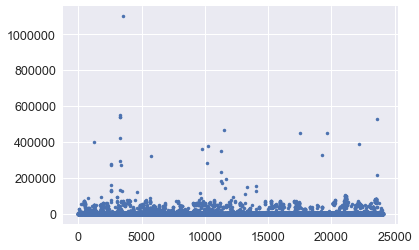

In [483]:
plt.plot(info,'.')